# Evaluación y Uso de ViT-Small para detección de pólipos

## Introducción

En este notebook, exploramos y evaluamos el rendimiento del modelo [ViT-Small](https://pprp.github.io/timm/models/vision-transformer/)
para la detección de pólipos cancerosos en imágen médica de colonoscopias.

Para ello utilizaremos el dataset de [**Piccolo**](https://huggingface.co/hustvl/yolos-base),
este dataset proporciona imágenes de colonoscopias tanto en RGB como en NBI.
Para la detección **modificaremos el modelo** el modelo para detectar los pólipos
usando bboxes.

### Objetivos

- Modificar el modelo **ViT-Small** para la detección de pópipos con bounding boxes.
- Entrenar el modelo con las imágenes medicas seleccionadas haciendo un **fine-tunning** para imágen médica.
- Mostar el rendimiento del mismo con el benchamark del modelo seleccionado

¡Comencemos con la evaluación del modelo!
## Pasos a seguir

1. Cargamos y analizamos el **dataset**
2. **Procesamos los datos** para cumplir con el formato de entrada del modelo
3. Cargamos y **modificamos el modelo** para detección de pólipos
4. **Entrenamos** el modelo con los datos obtenidos
4. **Evaluamos** el rendimiento

### 1- Cargar y analizar el dataset

Como hemos mencionado cargaremos el datset de [**Piccolo**](https://www.biobancovasco.bioef.eus/en/Sample-and-data-catalog/Databases/PD178-PICCOLO-EN.html),
el cuál tiene una cantidad rezonable de imágenes en RGB y NBI categorizadas por 
al pólipo al que pertenecen por lo que podemos usar la división pre hecha del dataset
y evitar asignar frames del mismo pólipo al train y validation invalidando los relustados.

Además mostraré informaciñon relevante de las imágenes escogidas

In [29]:
import sys
import os

path_to_add = os.path.abspath('../../utils')
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

from utils import ImageDatasetProcessor as idp

DS_PATH = "../../datasets"
DS_NAME = "Piccolo"
json_path = f"{DS_PATH}/piccolo_dataset/{DS_NAME}_dict.json"

# paths del dataset
paths_img = [
    # train paths
    (DS_PATH + "/piccolo_dataset/test/polyps",                      # polyps
     DS_PATH + "/piccolo_dataset/test/masks",                       # masks
     DS_PATH + "/piccolo_dataset/test/void", "test"  ,              # voids
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),      # light type

    # test paths
    (DS_PATH + "/piccolo_dataset/train/polyps",
     DS_PATH + "/piccolo_dataset/train/masks",
     DS_PATH + "/piccolo_dataset/train/void", "train",
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),

    # validation paths
    (DS_PATH + "/piccolo_dataset/validation/polyps",
     DS_PATH + "/piccolo_dataset/validation/masks",
     DS_PATH + "/piccolo_dataset/validation/void", "validation",
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv")]

# inicializamos el dataset con su nombre y fichero de formatos de imagen
dt_Piccolo = idp(target_resolution=(400, 240), dataset_name=DS_NAME,
                     json_path=json_path)

# procesamos el dataset si no existe el json
if not os.path.isfile(json_path):
    for path in paths_img:
        print(f"procesando conjunto: {path[3]}")
        dt_Piccolo.load_dataset(path[0], path[1], voids_path=path[2], 
                                split=path[3], light_csv=path[4])

#### Análisis del dataset
Como podemos ver es un dataset muy ordenado, con una cantidad representativa de
imágenes NBI por lo que es adecuado para el entrenamiento en ambos tipos de luz 
(WL, NBI).

Además podemos observar que es un dataset con una distribución de los pólipos
más o menos descentralizada.

In [30]:
dt_Piccolo.print_summary()

Total imágenes: 3177
Composición del dataset:
Resoluciónes: total distintas resoluciones 2
	480x854: 1771	1080x1920: 1406

Tipos de luz:
	WL: 1954	NBI: 1223

Splits:
	test: 223	train: 2247	validation: 707

Canales:
	polyp_RGB: 3177	mask_L: 3177	void_L: 3177

Tipos de lesión:


Volumen medio de los pólipos respecto a la imagen:	21.29018999577081%
Volumen medio de las bbox respecto a la imagen:	61.59645267611556%
Distancia media del centro del pólipos al centro de la imagen:	51.44542123516519px


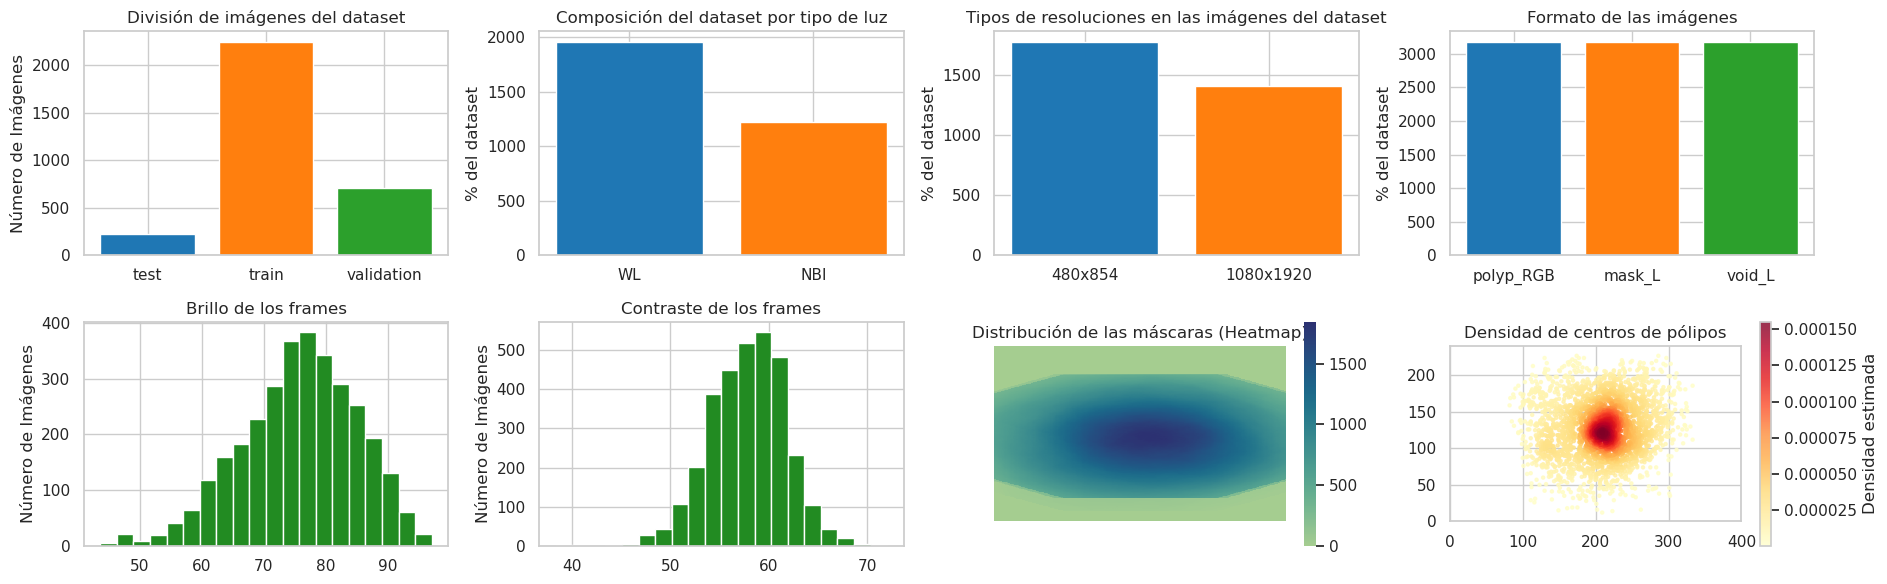

In [31]:
dt_Piccolo.graph_summary()

Finalmente veamos una muestra de una imágen aleatoria y su aspecto con la bbox

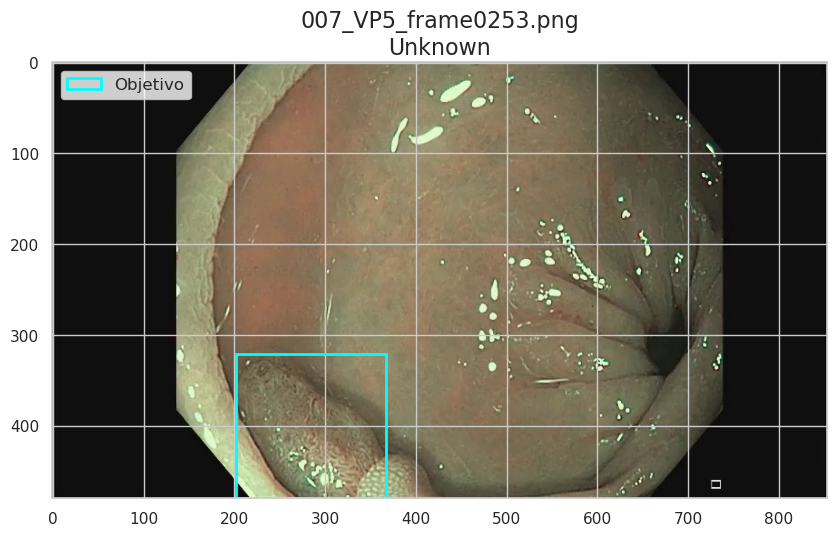

In [32]:
import random

# mostramos aleatoriamente una imágen del dataset
rand_key = random.choice(list(dt_Piccolo.dict.keys()))
dt_Piccolo.show_image(rand_key)


## Entrenamiento de ViT-Small

Para esta segunda entrenaremos el modelo de [ViT-Small](https://pprp.github.io/timm/models/vision-transformer/) **de la librería timm**,
con las imágenes del dataset de Piccolo, con la peculiaridad que trataremos con 
un modelo modificado para devolver solo las bboxes.

#### Pasos del entrenemiento
1. **Modificaremos el modelo** para entrenar y devolver tan solo las bboxes ya que 
ViT-Small ofrece la arquitectura del encoder ViT por lo que **añadiremos un head de detección**, en este caso una **MLP**, que devuelva las bboxes 

2. **Preparar todo para el entrenamiento**, esto son elementos como el 
optimizador y la función de pérdida además de juntar definitivamente los datos
en los splits adecuados y DataLoaders para usarlos en la función de entrenamiento

3. **Entrenar** el modelo y ir obteniendo datos del rendimiento del mismo para
poder mostrarlos más adelante

In [33]:
from transformers import YolosForObjectDetection
import torch.nn as nn
import torch

# Creamos una cabeza de deteccion siguiendo el formato de YOLO
class BBoxMLP(nn.Module):
    def __init__(self, in_features=384, hidden_dim=384, out_features=4):
        super(BBoxMLP, self).__init__()
        
        # Creamos la MLP de detección
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_dim),     # capa de entrada
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),      # capa intermedia
            nn.ReLU(),
            nn.Linear(hidden_dim, out_features)     # capa de salida
        )

    # debemos definir el forward ya que heredamos de nn.Module
    def forward(self, x):
        return self.mlp(x)  # ejecuta la sentencia de mlp

# Modificamos la arquitectura PVT para detectar con la cabeza BBoxMLP
class PVT4Detection(nn.Module):
    # Usamos el constructor original pero eliminando la MLP de clasificación
    # Esto evita que el modelo actualize en el backward esa MLP
    def __init__(self, PVT_model, bbox_head):
        super(PVT4Detection, self).__init__()  # iniciamos la clase padre antes de nada
        
        self.PVT = PVT_model
        self.head_bbox = bbox_head

    def forward(self, x):
        # x es la entrada de la imagen
        features = self.PVT(x)      # ejecutamos la PVT
        # forma de salida (batch_size, 512) -> ya tenemos los CLS
        bboxes = self.head_bbox(features)

        return {'pred_bboxes': bboxes}

#### Preparar el entrenamiento
Una vez modificado el modelo solo debemos preparar el entrenamiento, es decir:
- Definir los dataloders
- Cargar el modelo personaliazdo
- Definir las funciones de pérdida y optimizadores
- Definir una fuinciñon de entrenamiento

Utilizaremos el **optimizador Adalain** ya que es el usado en Yolos-base y la 
**loss fuction smooth_l1_loss** para las bbox de la salida ya que es información contínua

In [4]:
import timm
import torch.nn as nn

# Cargamos el modelo de la librería timm
PVT_model = timm.create_model('pvt_v2_b3', 
                              pretrained=True, num_classes=0)    # clas=0 sin detect head

# creamos el modelo con la cabeza personalizada de detección
model = PVT4Detection(PVT_model, BBoxMLP(in_features=512))  # última capa PVT 512
model.train()

Downloading: "https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b3.pth" to /home/sprieto/.cache/torch/hub/checkpoints/pvt_v2_b3.pth


PyramidVisionTransformerV2(
  (patch_embed): OverlapPatchEmbed(
    (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (stages): ModuleList(
    (0): PyramidVisionTransformerStage(
      (blocks): ModuleList(
        (0-2): 3 x Block(
          (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (q): Linear(in_features=64, out_features=64, bias=True)
            (kv): Linear(in_features=64, out_features=128, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=64, out_features=64, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (sr): Conv2d(64, 64, kernel_size=(8, 8), stride=(8, 8))
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine

#### Entrenamiento

Ahora por fin pasamos a entrenar el modelo y recopilar los dátos de análisis 
para ellos obtenemos el IoU de las bboxes, ya que al ser areas en al imágen no 
podemos medir un "accuracy" tal cual.

**IoU** es una métrica usada para este
tipo de situaciones en las que se calcula: **IoU=Area_interseccion/Area_union** 
por lo que es importante tener en cuenta que **un IoU 1 es una coincidencia exacta**



Resumen TRAIN:
Total imágenes: 2247
Composición del dataset:
Resoluciónes: total distintas resoluciones 2
	480x854: 1208	1080x1920: 1039

Tipos de luz:
	WL: 1359	NBI: 888

Splits:
	train: 2247

Canales:
	polyp_RGB: 2247	mask_L: 2247	void_L: 2247

Tipos de lesión:


Volumen medio de los pólipos respecto a la imagen:	20.953966464884672%
Volumen medio de las bbox respecto a la imagen:	62.630452943620185%
Distancia media del centro del pólipos al centro de la imagen:	51.37037561954898px


Resumen VALIDATION:
Total imágenes: 707
Composición del dataset:
Resoluciónes: total distintas resoluciones 2
	480x854: 340	1080x1920: 367

Tipos de luz:
	WL: 467	NBI: 240

Splits:
	validation: 707

Canales:
	polyp_RGB: 707	mask_L: 707	void_L: 707

Tipos de lesión:


Volumen medio de los pólipos respecto a la imagen:	24.555484272949045%
Volumen medio de las bbox respecto a la imagen:	60.8773159589096%
Distancia media del centro del pólipos al centro de la imagen:	50.06052466351384px


Resumen TEST:
Tota

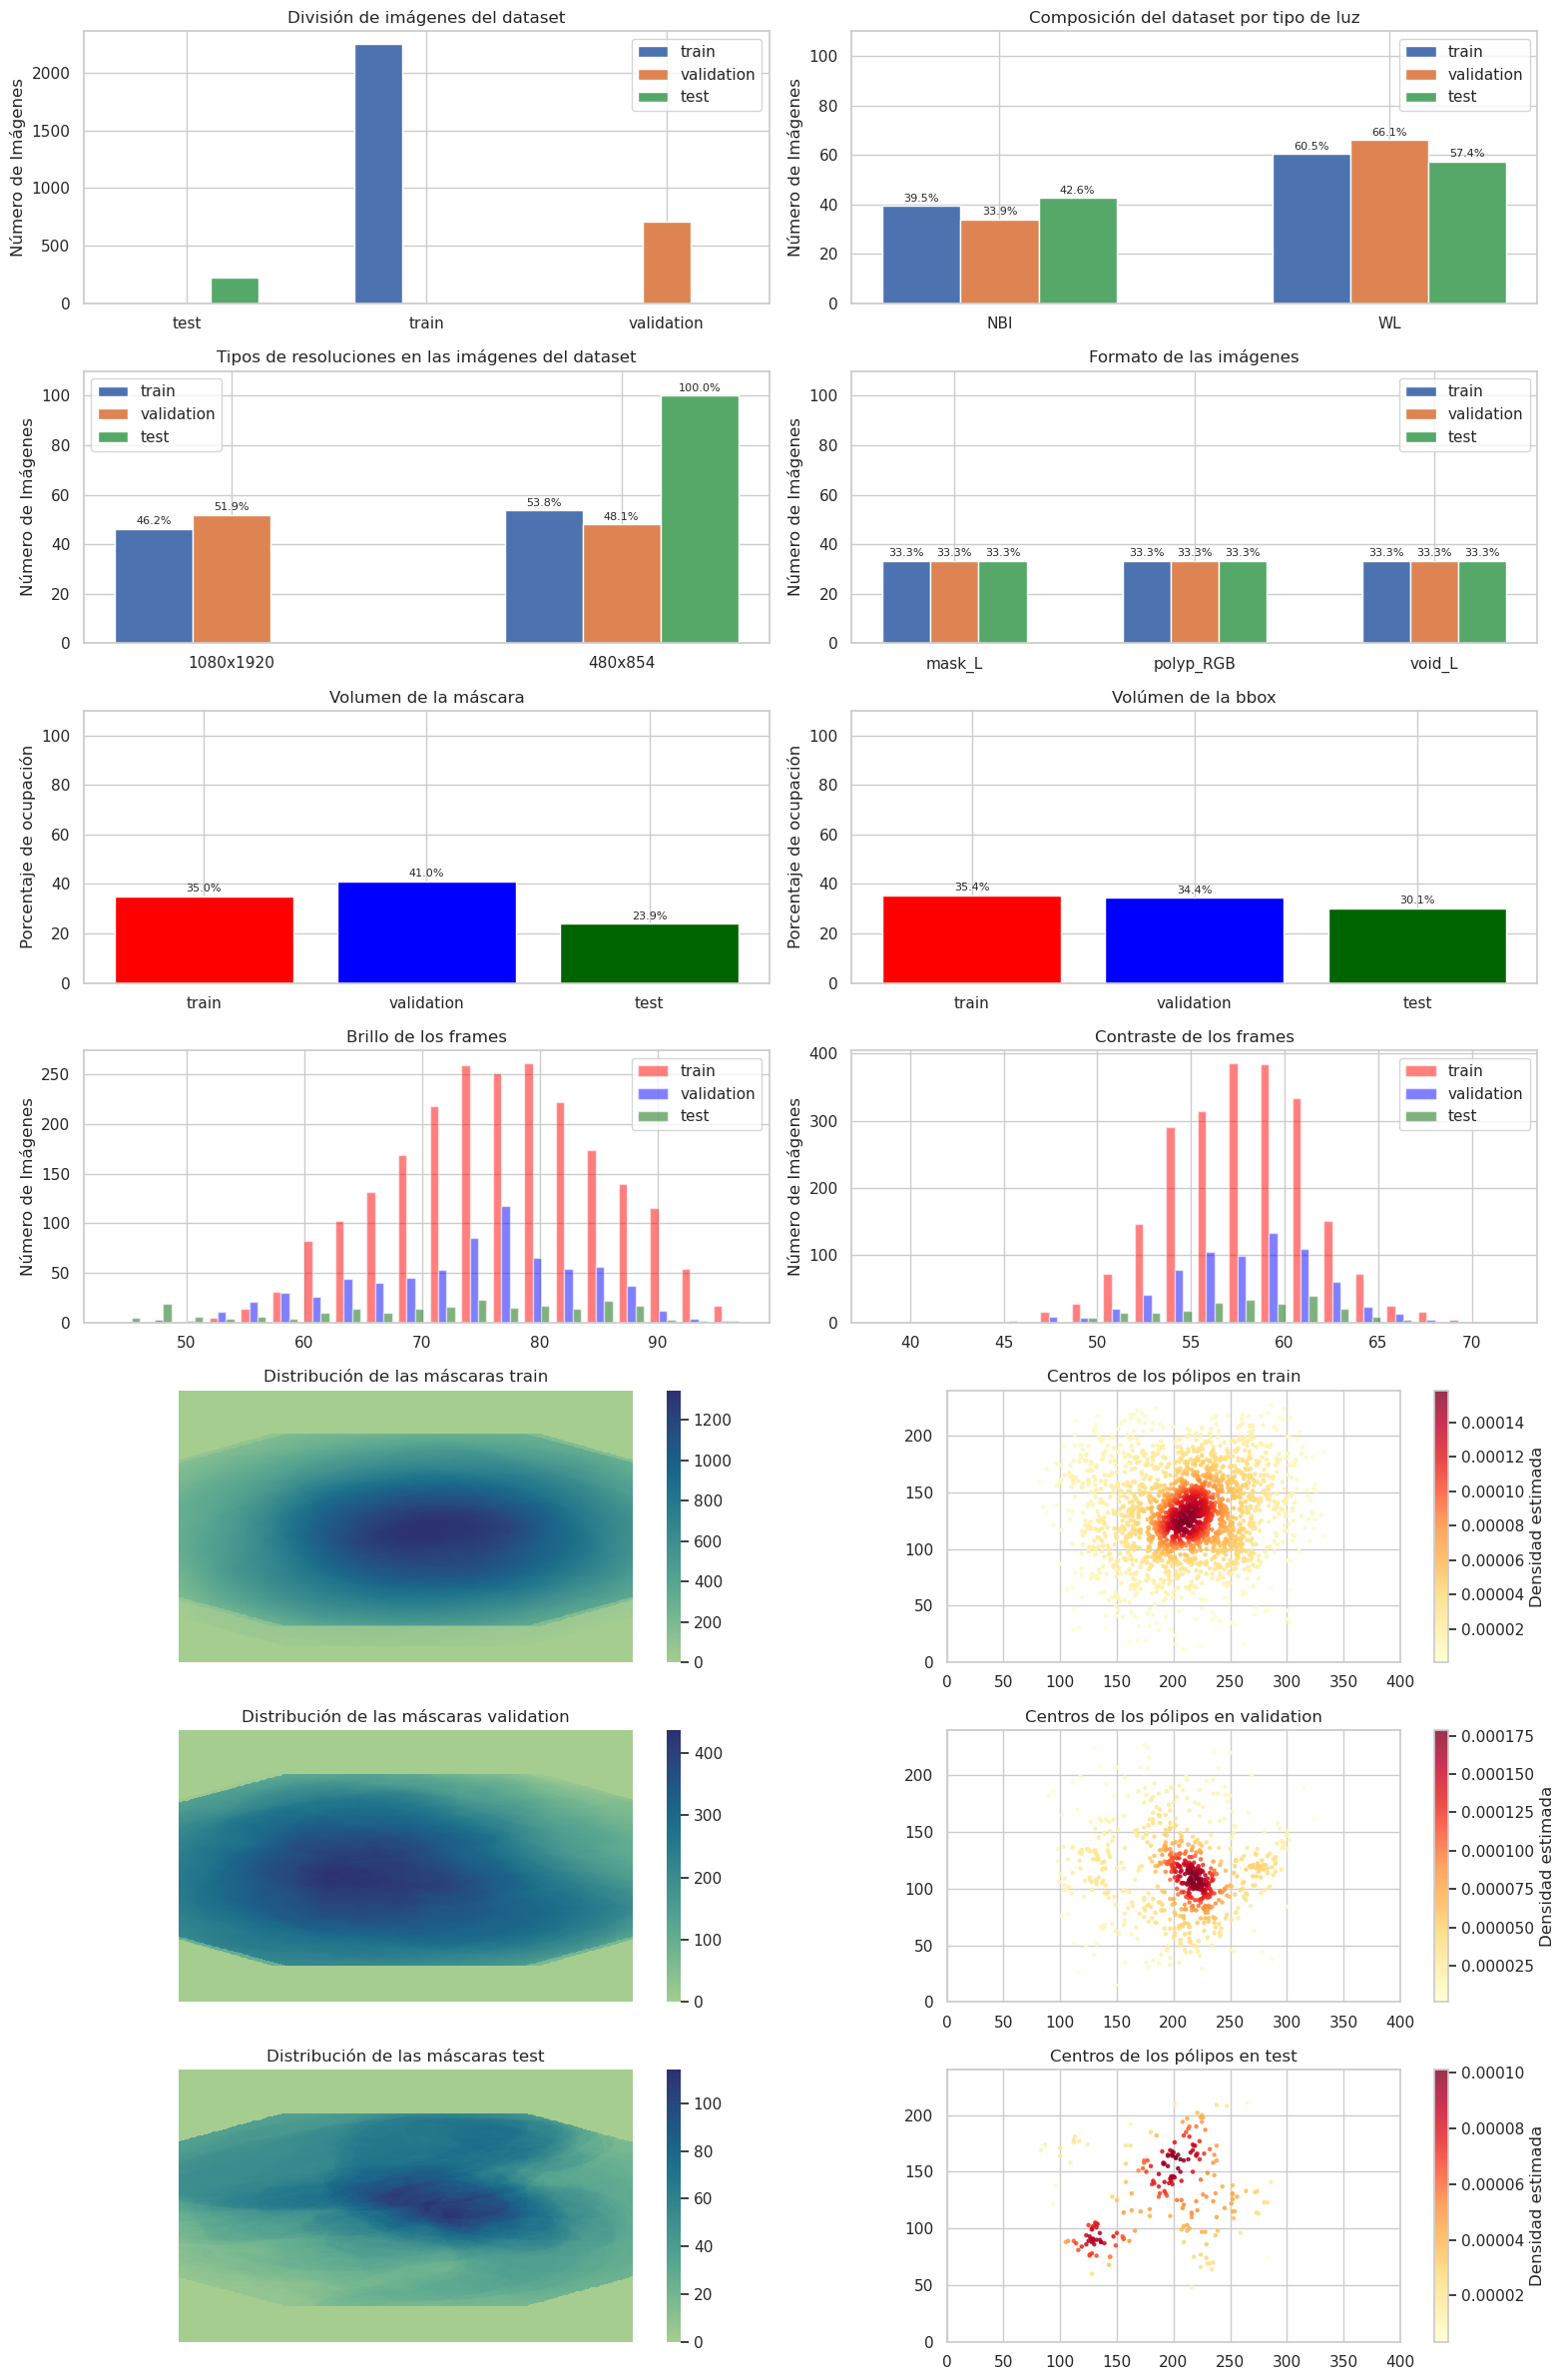

Entrenando en GPU 0
00:00 entrenamiento comenzado num épocas: 30
Época 0 07:20 
Época 0  Loss train 0.0011  IoU train 0.4299 
Época 0  Loss valid 0.0013  IoU valid 0.3876 
Época 1 14:53 
Época 1  Loss train 0.0004  IoU train 0.5499 
Época 1  Loss valid 0.0007  IoU valid 0.4809 
Época 2 20:54 
Época 2  Loss train 0.0002  IoU train 0.6477 
Época 2  Loss valid 0.0006  IoU valid 0.5097 
Época 3 26:25 
Época 3  Loss train 0.0001  IoU train 0.7109 
Época 3  Loss valid 0.0005  IoU valid 0.5411 
Época 4 32:05 
Época 4  Loss train 0.0001  IoU train 0.7512 
Época 4  Loss valid 0.0006  IoU valid 0.5047 
Época 5 37:41 
Época 5  Loss train 0.0001  IoU train 0.7765 
Época 5  Loss valid 0.0005  IoU valid 0.5642 
Época 6 43:15 
Época 6  Loss train 0.0000  IoU train 0.8008 
Época 6  Loss valid 0.0005  IoU valid 0.5279 
Época 7 48:48 
Época 7  Loss train 0.0000  IoU train 0.8075 
Época 7  Loss valid 0.0005  IoU valid 0.5563 
Época 8 54:21 
Época 8  Loss train 0.0000  IoU train 0.8104 
Época 8  Loss vali

In [35]:
from utils import TrainModel as trm
from torch.optim import Adam
import json

# definimos los parametros del entrenamiento 🏃‍♂
MODEL_NAME = "PVT"
NUM_EPOCH = 30              # 🔄 Numero de epocas del entrenamiento 
BATCH_SIZE = 10             # 👝 Numero de imágenes por batch
TRAIN_RES = (244, 244)      # 📷 Resolucion entreno requerida por PVT
RESULTS_JSON = f"../../resultados/{DS_NAME}_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}.json"
RESULTS_IMG = f"../../resultados/{DS_NAME}_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}.png"
json_exists = False     # flag para comprobar si tnemos un json

# Obtener los diccionarios con formato de entrenamiento
train_loader, val_loader, test_loader = dt_Piccolo.get_dataloaders(
                                            BATCH_SIZE, 
                                            use_premade_splits=True)

# definimos el optimizador y la loss function
def loss_fn(target, pred):
    return nn.functional.smooth_l1_loss(pred, target)

optimizer = Adam(model.parameters(), lr=5e-5)
trainer = trm(model, loss_fn=loss_fn, optim=optimizer)

# si ya tenemos los resulados no volvemos a entrenar
if os.path.isfile(RESULTS_JSON):
    with open(RESULTS_JSON, "r", encoding="utf-8") as json_file:
            train_results = json.load(json_file)
    json_exists = True

if not json_exists:
    train_results = trainer.train_model(NUM_EPOCH, TRAIN_RES, 
                                    train_loader, val_loader, test_loader)

    # guardamos los datos
    with open(RESULTS_JSON, "w", encoding="utf-8") as json_file:
        json.dump(train_results, json_file)  # `indent=4` para formato legible

## Análisis de los resultados

Una vez entrenado el modelo y finalizada la obtencion de datos durante el entrenamiento,
además de disponer de los datos de test vamos a graficar los resultados y ver 
que tal ha ido el entrenamiento.

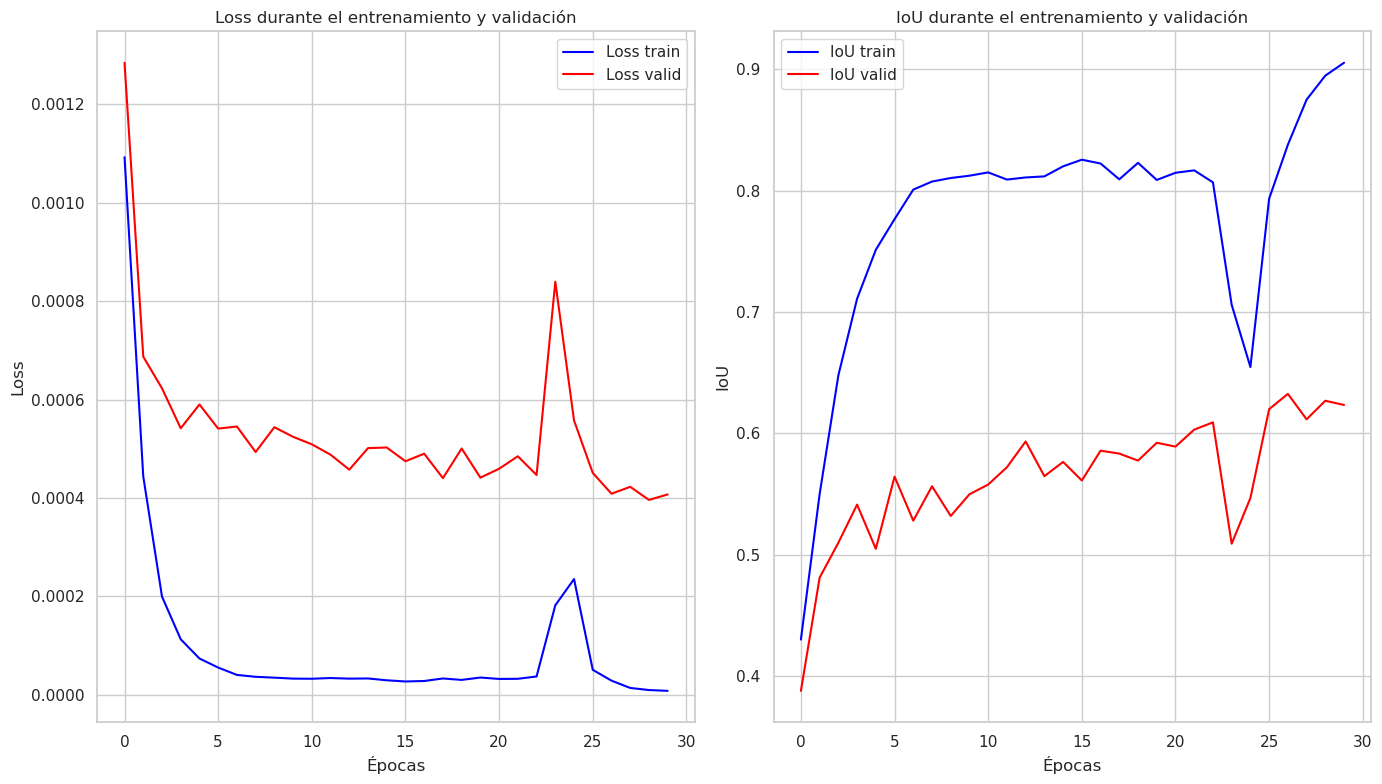

End of training!
-------------------- FINAL RESULTS ------------------------
|     - Test loss:	0.000238                      |
|     - Test IoU:	0.654                        |
-----------------------------------------------------------


In [36]:
trainer.show_results(train_results, save_img=True, img_name=RESULTS_IMG)